# Introduction 

The goal of this project will be to make predictions of chess games outcomes. The training data used was downloaded in the [fetch_chess_data](https://erikgrip.github.io/fetch_chess_data/) project.  

In the following notebooks we will  
* explore the dataset  
* define the outcome that we'll try to predict  
* Split data into train and test sets
* contruct features  
* train and evaluate a model


## Exploratory data Analysis of downloaded Chess.com data

In [2]:
# Import packages
import pandas as pd
import pyarrow.parquet as pq
import json
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
default_color = 'steelblue'

### Load data and metadata

In [3]:
# Load parquet data
parquet_table = pq.read_table('/home/jovyan/work/data/data.parquet')

# Extract metadata from the fetch_chess_data run
fetch_metadata = json.loads(parquet_table.schema.metadata[b'fetch_metadata'])

# Read data into a pandas DataFrame : df
df = parquet_table.to_pandas()

### Show metadata

In [4]:
PLAYER_NAME = fetch_metadata['player_name']
DATA_TS = fetch_metadata['fetch_timestamp']
LOCAL_TZ = fetch_metadata['timestamps_localized_to']

print("Player name:", PLAYER_NAME)
print("Data fetch timestamp:", DATA_TS)
print("Data time zone:", LOCAL_TZ)

Player name: gripklo
Data fetch timestamp: 2021-12-21 10:43:07
Data time zone: CET


### Describe data  
Let's start with the summary info

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   game_id           4369 non-null   int64  
 1   start_date_local  4369 non-null   object 
 2   start_time_local  4369 non-null   object 
 3   end_date_local    4369 non-null   object 
 4   end_time_local    4369 non-null   object 
 5   event             4369 non-null   object 
 6   site              4369 non-null   object 
 7   time_class        4369 non-null   object 
 8   time_control      4369 non-null   object 
 9   result            4369 non-null   object 
 10  result_str        4369 non-null   object 
 11  termination       4369 non-null   object 
 12  eco               4367 non-null   object 
 13  name              4369 non-null   object 
 14  color             4369 non-null   object 
 15  is_white          4369 non-null   int64  
 16  is_black          4369 non-null   int64  


None

There are no missing values in the data, except for 2 eco values. For a ML prediction task this ia a rather small dataset which will impact both the suitable methods and the ceiling of the model performance.

#### Time class : filtering blitz games  
A big majority of the games are in the Blitz time class. Since the games in different time classes probably won't be comparable let's narrow down to blitz games straight away.

In [6]:
display(df['time_class'].value_counts())

# Filter df
df = df.loc[df['time_class'] == 'blitz'].copy()
print("\nNumber of games in df after filtering:", len(df))

blitz     4054
bullet     188
rapid       97
daily       30
Name: time_class, dtype: int64


Number of games in df after filtering: 4054


This is an overview of the distributions of the numeric columns:

In [7]:
display(df.describe())

,game_id,is_white,is_black,rating,is_win,is_loss,is_draw,won_points,opp_rating
count,4.054000e+03,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000
mean,1.858366e+10,0.500247,0.499753,1500.486433,0.480513,0.475086,0.044401,0.502713,1498.902072
std,1.038153e+10,0.500062,0.500062,44.171762,0.499682,0.499441,0.206009,0.488827,56.566619
min,5.946909e+09,0.000000,0.000000,1030.000000,0.000000,0.000000,0.000000,0.000000,995.000000
25%,6.559170e+09,0.000000,0.000000,1472.250000,0.000000,0.000000,0.000000,0.000000,1461.000000
50%,2.154602e+10,1.000000,0.000000,1499.000000,0.000000,0.000000,0.000000,0.500000,1498.000000
75%,2.823704e+10,1.000000,1.000000,1527.000000,1.000000,1.000000,0.000000,1.000000,1534.000000
max,3.382196e+10,1.000000,1.000000,1650.000000,1.000000,1.000000,1.000000,1.000000,1701.000000


In [8]:
display(df.describe(include=['object']))

,start_date_local,start_time_local,end_date_local,end_time_local,event,site,time_class,time_control,result,result_str,termination,eco,name,color,opp_name
count,4054,4054,4054,4054,4054,4054,4054,4054,4054,4054,4054,4054,4054,4054,4054
unique,264,3884,264,3888,1,1,1,3,3,3,8,112,1,2,3696
top,2021-12-17,22:31:02,2021-12-17,16:33:02,Live Chess,Chess.com,blitz,180,1-0,Win,resignation,C00,gripklo,White,AAA800
freq,88,4,88,3,4054,4054,4054,3391,1994,1948,1917,932,4054,2028,6


The columns 'event', 'site', and 'time_class' only have one unique value, so they won't be interesting to analyse.


### Calendar time line
Plot how the games are spread out over the time line.

In [9]:
# Create additional columns for convenience
df['start_ts'] = pd.to_datetime(df['start_date_local'].astype('str') + " " +  df['start_time_local'].astype('str'))
df['end_ts'] = pd.to_datetime(df['end_date_local'].astype('str') + " " +  df['end_time_local'].astype('str'))

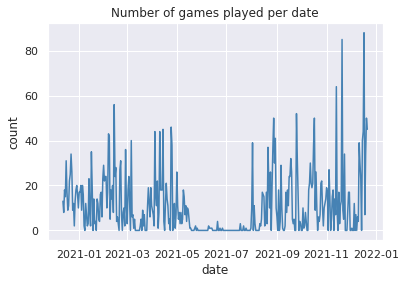

In [10]:
# Plot the history of played games
plot_df = (
    df.groupby(pd.Grouper(key='start_ts', freq='D')).size()
    .reset_index()
    .rename(columns={'start_ts': 'date', 0: 'count'})
)

sns.lineplot(data=plot_df, x='date', y='count', color=default_color)
plt.title('Number of games played per date')
plt.show()

The games were all played between December 2020 and December 2021. There was a distinct dip in volume in Jule and July.

### Time of day  
Show how the games spread over the hours of the day.

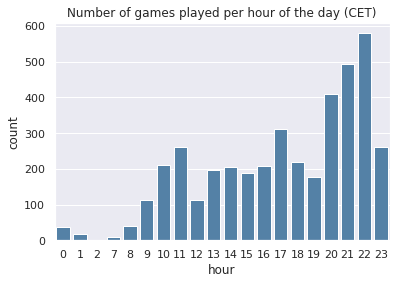

In [11]:
plot_df = (
    df['start_ts'].dt.hour
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'hour', 'start_ts': 'count'})
)

sns.barplot(data=plot_df, x='hour', y='count', color=default_color)
plt.title(f"Number of games played per hour of the day ({LOCAL_TZ})")
plt.show()

Night time games are rare. From 9 AM there are more games and the spike is at 8-10 PM.

### Weekday

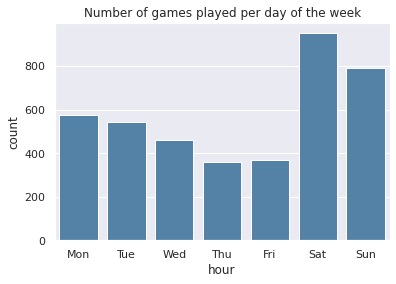

In [12]:
plot_df = (
    df['start_ts'].dt.weekday
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'hour', 'start_ts': 'count'})
)

sns.barplot(data=plot_df, x='hour', y='count', color=default_color)
plt.title(f"Number of games played per day of the week")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6],
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

Most games were player in the weekend, while Thursdays and Fridays are the days with the least games.

### Hour and weekday relation

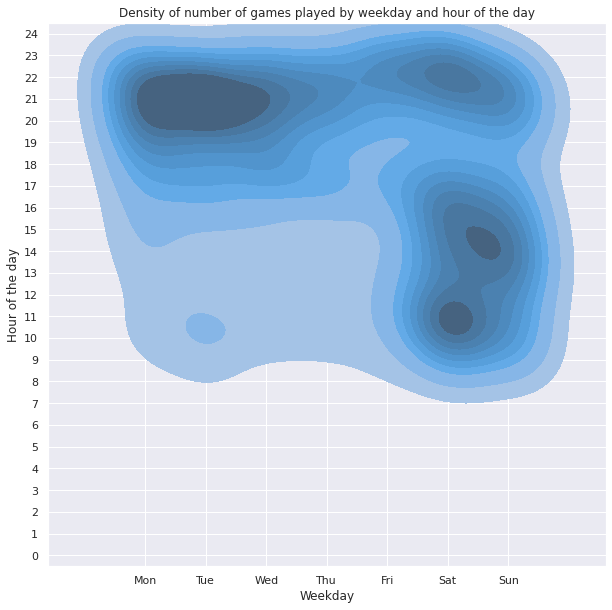

In [13]:
plt.figure(figsize=(10, 10))
sns.kdeplot(x=df['start_ts'].dt.weekday, y=df['start_ts'].dt.hour, color=default_color, fill=True)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6],
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Weekday')
plt.ylabel('Hour of the day')
plt.ylim([-0.5, 24.5])
plt.yticks([t for t in range(0, 25)])
plt.title("Density of number of games played by weekday and hour of the day")
plt.show()

While all weekdays have games in the evening, it's more common for weekend games to have been played between 11:00 and 18:00.

### Game duration

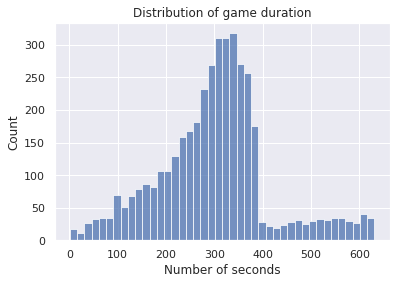

In [14]:
df['duration_sec'] = (df['end_ts'] - df['start_ts']).dt.total_seconds()

sns.histplot(df['duration_sec'])
plt.title(f'Distribution of game duration')
plt.xlabel("Number of seconds")
plt.show()

Remember that there's different time classes in the data, which makes for an odd looking total distribution. The most common time control, as we'll se next, is 3 minutes and those games can be max 360 seconds long.

### Game time control
This column shows the number of seconds the players had at their disposal at for the game.

In [15]:
display(df['time_control'].value_counts())

180      3391
300       642
180+2      21
Name: time_control, dtype: int64

A big majority of the games are some variant of 3 minute games. When for example '180+2', that means each players got 2 extra seconds on their clock per played move - practically turning it into a 4 minute game rather than a 3 minute game. They're rare in the data though.

### Game result  
There are 6 columns that are related to the result: **result**, **result_str**, **won_points**, **is_win**, **is_draw** and **is_loss**.

In [16]:
display(df['result'].value_counts())

1-0        1994
0-1        1880
1/2-1/2     180
Name: result, dtype: int64

This column doesn't take into account who played which color, and for that reason won't be interesting in this analysis.

In [17]:
display(df['result_str'].value_counts())
print("")
display(df['won_points'].value_counts())

Win     1948
Loss    1926
Draw     180
Name: result_str, dtype: int64

1.0    1948
0.0    1926
0.5     180
Name: won_points, dtype: int64

Those columns won't need both of these columns since they're essentially the same.

In [18]:
# The is_win, is_draw and is_loss columns are dummies for the different results
display(df['is_win'].value_counts().sort_index())
display(df['is_draw'].value_counts())
display(df['is_loss'].value_counts())

0    2106
1    1948
Name: is_win, dtype: int64

0    3874
1     180
Name: is_draw, dtype: int64

0    2128
1    1926
Name: is_loss, dtype: int64

### Color  
The columns **color**, **is_white** and **is_black** all hold info on if the player played the white or black pieces in the game.

In [19]:
display(df['color'].value_counts())
print("")
display(df['is_white'].value_counts())
print("")
display(df['is_black'].value_counts())

White    2028
Black    2026
Name: color, dtype: int64

1    2028
0    2026
Name: is_white, dtype: int64

0    2028
1    2026
Name: is_black, dtype: int64

Almost exactly 50We'll only need one of the three columns. Let's keep is_white and drop the other two.

### Game termination  
The termination columns tells in what way the game ended. 

The abandoned game could warrant some extra attention. It's not uncommon that players abandon games in losing position, in effect resigning. But having a bad internet connection could also result in an abandon game.

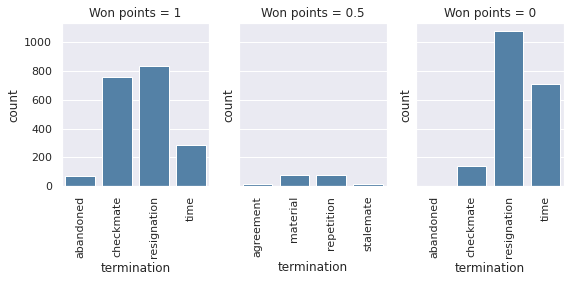

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

ax=0
for result in [1, 0.5, 0]:
    sns.countplot(data=df[df['won_points'] == result].sort_values('termination'), x='termination', ax=axs[ax], color=default_color)
    axs[ax].title.set_text(f'Won points = {result}')
    axs[ax].set_xticklabels(axs[ax].get_xticklabels(), rotation=90)
    ax += 1

Most of the games with a winner were resigned by either player. Losing by time is more common than winning by time, while winning by checkmate is far moe common than losing by checkmate.
For drawn games the thermination distrubution is more even. 

### ECO code  
Chess openings are classified in a system called ECO. Depending on how the first moves develop the game will be tagged with a specific code. Since the ECO won't be known when the game starts it won't be available for prediction.

In [21]:
# Print most common openings in data
display(df['eco'].value_counts().head(10))

C00    932
B22    341
C02    195
B01    193
C01    178
C41    176
A45    170
A00    156
B00    115
C62    114
Name: eco, dtype: int64

More than half of the games are in one of the top ten ECO codes. The most common is C00 which is French Defense. The openings are categorized by the initial letter. Let's see the distribution by category.

In [22]:
display(df['eco'].str[:1].value_counts())

C    2242
B     995
A     627
E     164
D      26
Name: eco, dtype: int64

### Player Rating

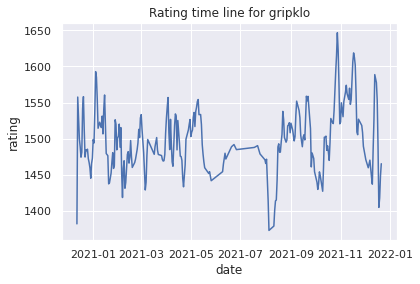

In [23]:
# Plot the player's (mean) rating over time
plot_df = (
    df.groupby(pd.Grouper(key='start_ts', freq='D'))['rating'].mean()
    .reset_index()
    .rename(columns={'start_ts': 'date', 0: 'mean'})
)

sns.lineplot(data=plot_df, x='date', y='rating')
plt.title(f'Rating time line for {PLAYER_NAME}')
plt.show()

There's no clear trend over time.

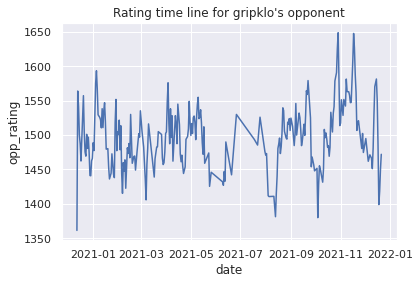

In [24]:
# Plot the opponent's mean rating over time
plot_df = (
    df.groupby(pd.Grouper(key='start_ts', freq='D'))['opp_rating'].mean()
    .reset_index()
    .rename(columns={'start_ts': 'date', 0: 'mean'})
)

sns.lineplot(data=plot_df, x='date', y='opp_rating')
plt.title(f'Rating time line for {PLAYER_NAME}\'s opponent')
plt.show()

The opponents ratings don't have an apparent pattern either, execpt for following gripklo's rating.

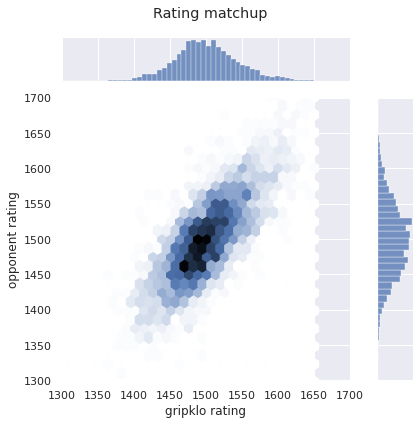

In [29]:
# Show joint plot rating / opponent rating
sns.jointplot(data=df, x='rating', y='opp_rating', kind='hex')

plt.suptitle('Rating matchup')
plt.xlabel(f"{PLAYER_NAME} rating")
plt.ylabel("opponent rating")
plt.xlim([1_300, 1_700])
plt.ylim([1_300, 1_700])
plt.tight_layout()
plt.show()

Both distributions are bell-shaped, and as expected there's a clear correlation meaning the higher your rating, the higher rated opponents you'll face. Lastly, let's plot the distribution of the difference between the ratings in each game.

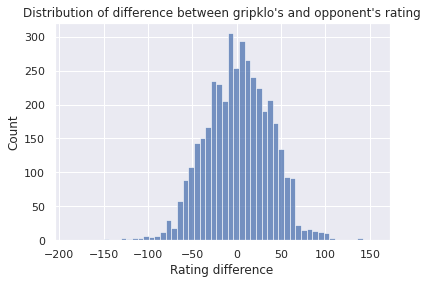

In [45]:
sns.histplot(df['rating'].sub(df['opp_rating']))
plt.title(f'Distribution of difference between {fetch_metadata["player_name"]}\'s and opponent\'s rating')
plt.xlabel("Rating difference")
plt.show()

This also looks like a normal-ish distribution centered at 0.

### Opponent name

In [49]:
# Display top 10 opponents in terms of game count
df['opp_name'].value_counts().head(10)

AAA800              6
hamzaph2001         6
FairYouth           6
Luuuurking          6
bourguibamohamed    6
ssv_cool            5
rudolfbaer          5
D3gaz               4
solkosky            4
BastiLor            4
Name: opp_name, dtype: int64

Although some opponents appear in several records there's no outlier that stands for a significant part of the games.

In [46]:
# Show the opponents who were played most frequently
display(df['opp_name'].value_counts().head(10))

AAA800              6
hamzaph2001         6
FairYouth           6
Luuuurking          6
bourguibamohamed    6
ssv_cool            5
rudolfbaer          5
D3gaz               4
solkosky            4
BastiLor            4
Name: opp_name, dtype: int64

There's no particular opponent that stands out in terms of frequency.

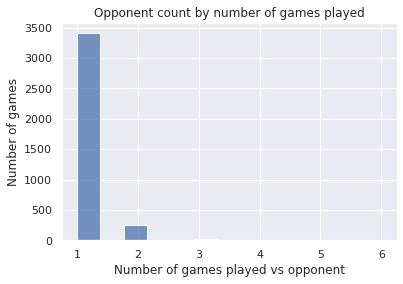

In [47]:
sns.histplot(df['opp_name'].value_counts())

plt.xlabel('Number of games played vs opponent')
plt.ylabel('Number of games')
plt.title("Opponent count by number of games played")
plt.show()